# [WIP] Visualization

This is a reproduction of the following paper.

Okada, I., Yamamoto, H., Akiyama, E. & Toriumi, F.\
Cooperation in spatial public good games depends on the locality effects of game, adaptation, and punishment.\
Sci Rep 11, 7642 (2021).\
https://doi.org/10.1038/s41598-021-86668-3

In [1]:
using CSV: read
using DataFrames: DataFrame, groupby, combine, mapcols, unstack, nrow, Not, select!
using Plots: plot, heatmap, palette, annotate!, text, Measures
using Statistics: mean

# don't omit DataFrame's columns
ENV["COLUMNS"] = 1000

1000

In [2]:
# データをCSVファイルから読み込む。
df = read(
    # "data/20211003_142614.csv", # 81%, 9%, 9%, 1% で CP, CN, DP, DN に戦略配分
    # "data/20211009_145316.csv", # 25% で均等に CP, CN, DP, DN に戦略配分
    # "data/20211009_205928.csv", # 25% で均等に CP, CN, DP, DN に戦略配分 (デバッグ1 calc_payoffs! でpayoffを追加ではなく上書きにしただけだけど、なぜか結果が変わっているような気がする)
    # "data/20211010_011841.csv", # 25% で均等に CP, CN, DP, DN に戦略配分 (デバッグ1+2 乱数シードをミリ秒の値にして、model生成時に確実にシードが変わるように変更)
    "data/20211010_114029.csv", # デバッグ1+2+3 set_next_strategy!のロジックを修正。→ p=0.0に関しては劇的に改善。但し、p≠0.0に関しては変わらず。
    DataFrame,
    header=[:step, :id, :g, :p, :a, :trial, :cooperator, :punisher],
    types=[Int, Int, Float64, Float64, Float64, Int, Int, Int]
)

min_step, max_step = minimum(df.step), maximum(df.step)
min_id, max_id = minimum(df.id), maximum(df.id)
min_trial, max_trial = minimum(df.trial), maximum(df.trial)
min_g, max_g = minimum(df.g), maximum(df.g)
min_p, max_p = minimum(df.p), maximum(df.p)
min_a, max_a = minimum(df.a), maximum(df.a)
println((min_step, max_step), (min_id, max_id), (min_trial, max_trial), (min_g, max_g), (min_p, max_p), (min_a, max_a))

(0, 100)(1, 100)(1, 100)(0.0, 1.0)(0.0, 1.0)(0.0, 1.0)


## Figure 1. Average cooperation rates in 100 trials after 100 generations. 

In [3]:
df_last_step = df[df.step .== max_step, [:g, :p, :a, :cooperator]]
df_last_step = groupby(df_last_step, [:g, :p, :a])
df_last_step = combine(df_last_step, :cooperator => mean)

# 協力度が0.01以上の行のみ表示
display(sort!(df_last_step[df_last_step.cooperator_mean .> 0.01, :], :cooperator_mean, rev = true))

,g,p,a,cooperator_mean
,Float64,Float64,Float64,Float64
1,0.0,0.0,0.0,0.8796
2,0.75,0.0,0.0,0.8758
3,0.5,0.0,0.0,0.8504
4,0.25,0.0,0.0,0.8066
5,0.0,0.0,0.5,0.6638
6,0.0,0.0,0.25,0.651
7,1.0,0.0,0.0,0.5076
8,0.0,0.0,1.0,0.4953
9,0.0,0.0,0.75,0.4873


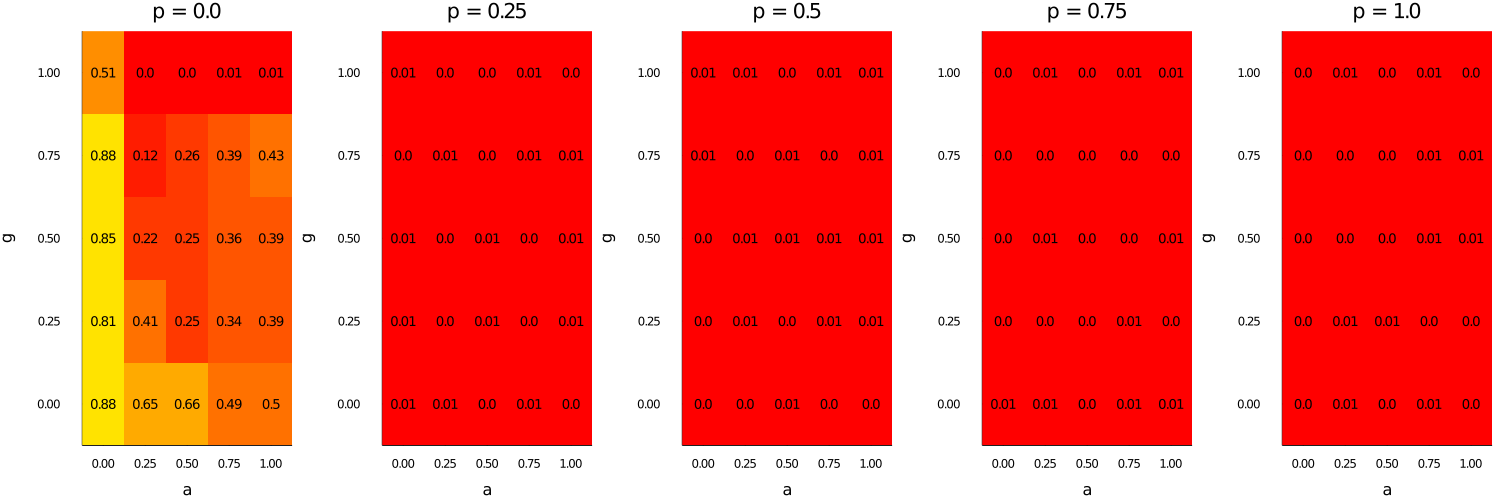

In [4]:
heatmaps = map(min_p:0.25:max_p) do _p
    # aをx軸、gをy軸とする
    _df = unstack(df_last_step[df_last_step.p .== _p, :], :a, :cooperator_mean)

    # DFをマトリクスに変換
    _values = Matrix(_df[:, Not([:p, :g])])

    # ヒートマップ
    heatmap(
        min_a:0.25:max_a,
        min_g:0.25:max_g,
        _values,
        fill_z=_values,
        title="p = $(_p)",
        xlabel="a",
        ylabel="g",
        clim=(0, 1),
        color=palette([:red, :yellow], 10),
        colorbar=:none
    )

    # アノテーション (x,y軸が反転しているのが気になる)
    ann = [(_a , _g, text(round(_values[Int(_g*4+1), Int(_a*4+1)], digits=2), 9, :black, :center)) for _a in min_a:0.25:max_a for _g in min_g:0.25:max_g]
    annotate!(ann)
end

plot(
    heatmaps...,
    layout=(1, 5),
    size=(1500, 500),
    fmt=:png,
    top_margin=Measures.Length(:mm, 3.0),
    left_margin=Measures.Length(:mm, 6.0),
    right_margin=Measures.Length(:mm, 0.0),
    bottom_margin=Measures.Length(:mm, 6.0)
)

## Figure 2. Transition diagram of strategy in 100 generation.

In [5]:
function transform_df(_df::DataFrame, _g::Float64, _p::Float64, _a::Float64, _trial::Int)::DataFrame
    _df = _df[(_df.g .== _g) .& (_df.p .== _p) .& (_df.a .== _a) .& (_df.trial .== _trial), [:step, :id, :cooperator, :punisher]]
    _df.strategy = map(x -> Bool(x) ? "C" : "D", _df.cooperator) .* map(x -> Bool(x) ? "P" : "N", _df.punisher)
    _df = _df[:, [:step, :id, :strategy]]

    return unstack(_df, :id, :strategy)
end

transform_df (generic function with 1 method)

In [6]:
# 協力度がベスト1, 25, 50, 75, 100の試行番号を抽出する
function get_trial_numbers(_df::DataFrame, _g::Float64, _p::Float64, _a::Float64)::Vector{Int64}
    _df = _df[(_df.step .== max_step) .& (_df.g .== _g) .& (_df.p .== _p) .& (_df.a .== _a), [:trial, :cooperator]]
    _df = groupby(_df, :trial)
    _df = combine(_df, :cooperator => mean)
    _trial_numbers = sort(_df, :cooperator_mean, rev = true).trial
    _trial_numbers = [_trial_numbers[_ranking] for _ranking in [1, 25, 50, 75, 100]]
    
    return _trial_numbers
end

get_trial_numbers (generic function with 1 method)

From the top, each row is a case of different values of (g, p, a): 
- (a)(1, 1, 1)
- (b)(0.5, 0.25, 0)
- (c)(0, 0, 0)
- (d)(0, 0, 1)
- (e)(1, 0, 0)
- (f)(0, 1, 0)
- (g)(0.5, 0, 0.5)

An agent whose strategy is 
- CP is colored in light blue,
- CN in pink,
- DP in red, and
- DN in dark blue. 

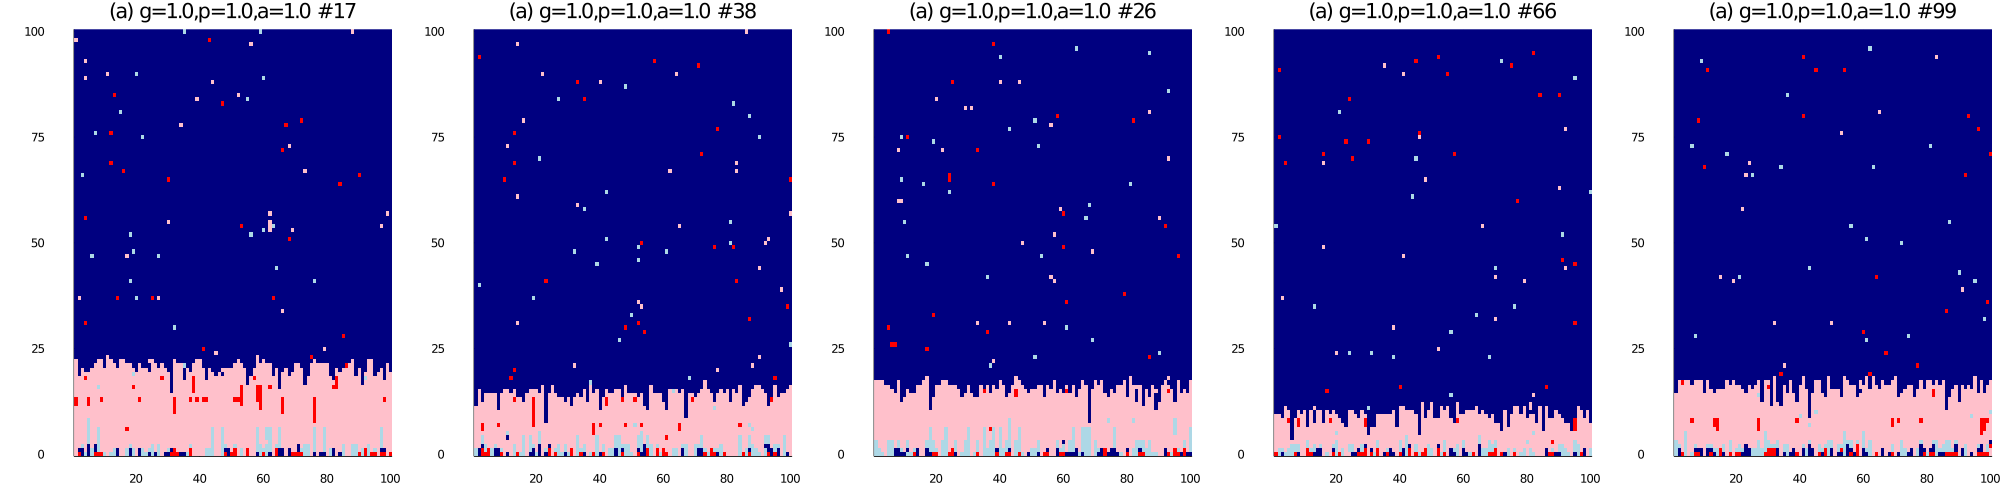

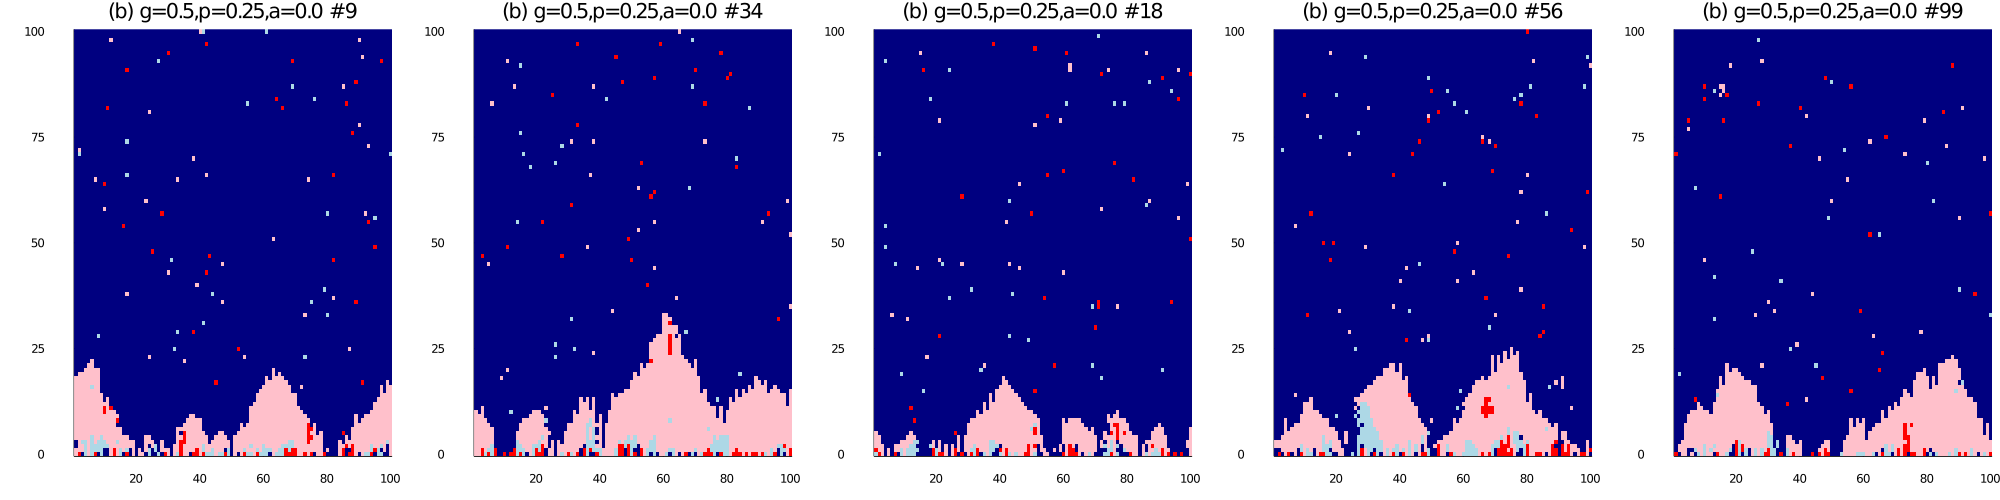

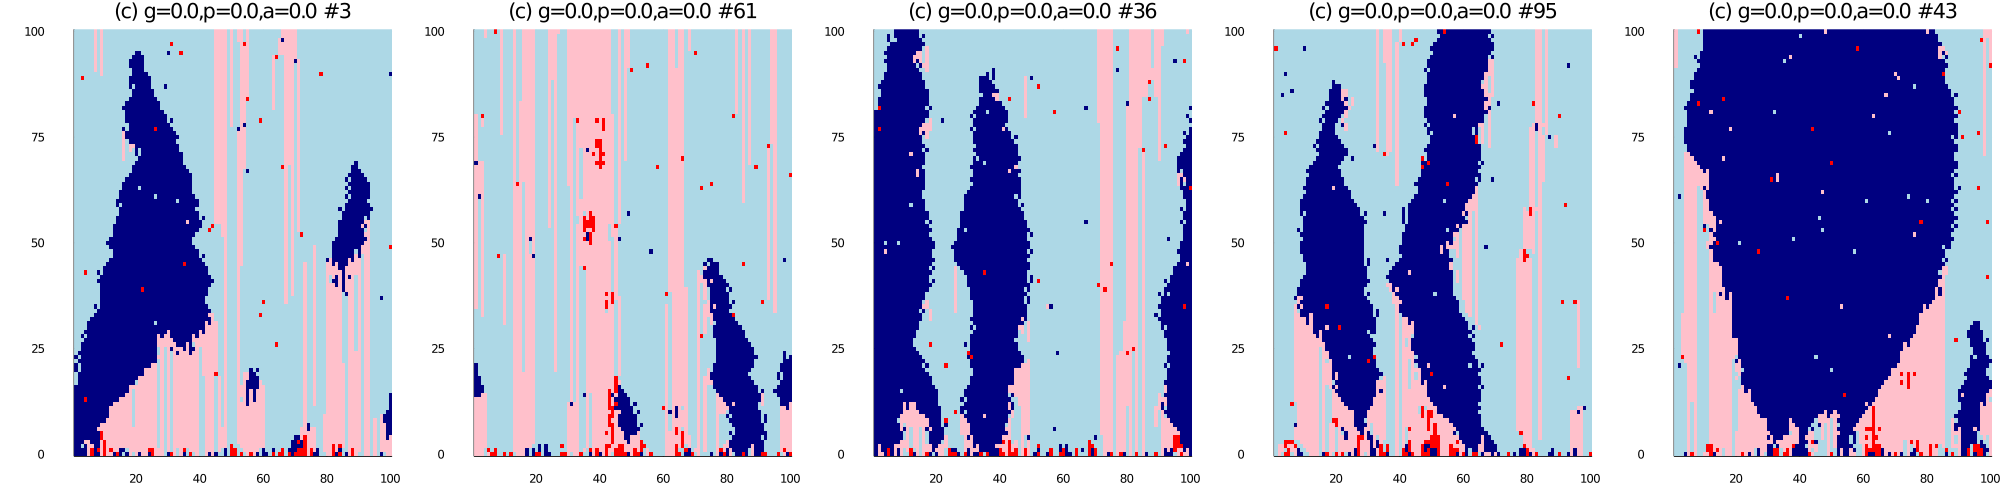

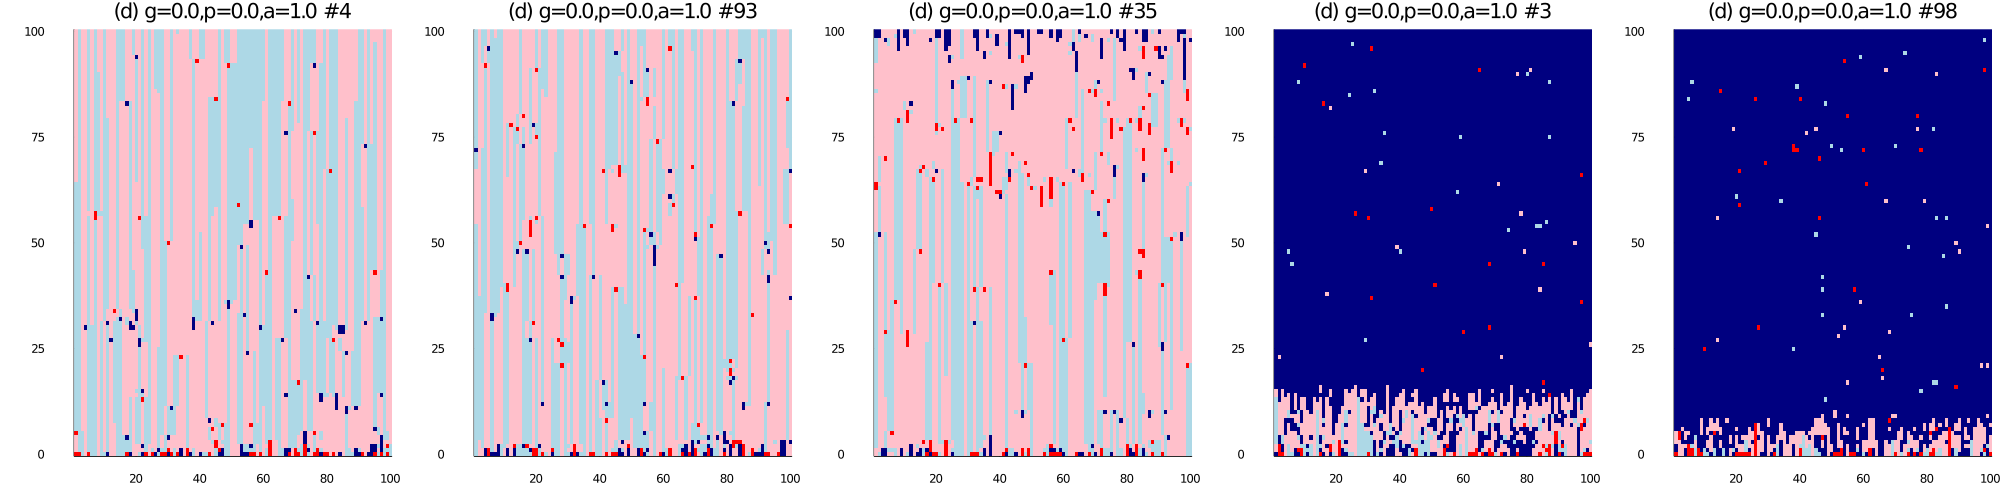

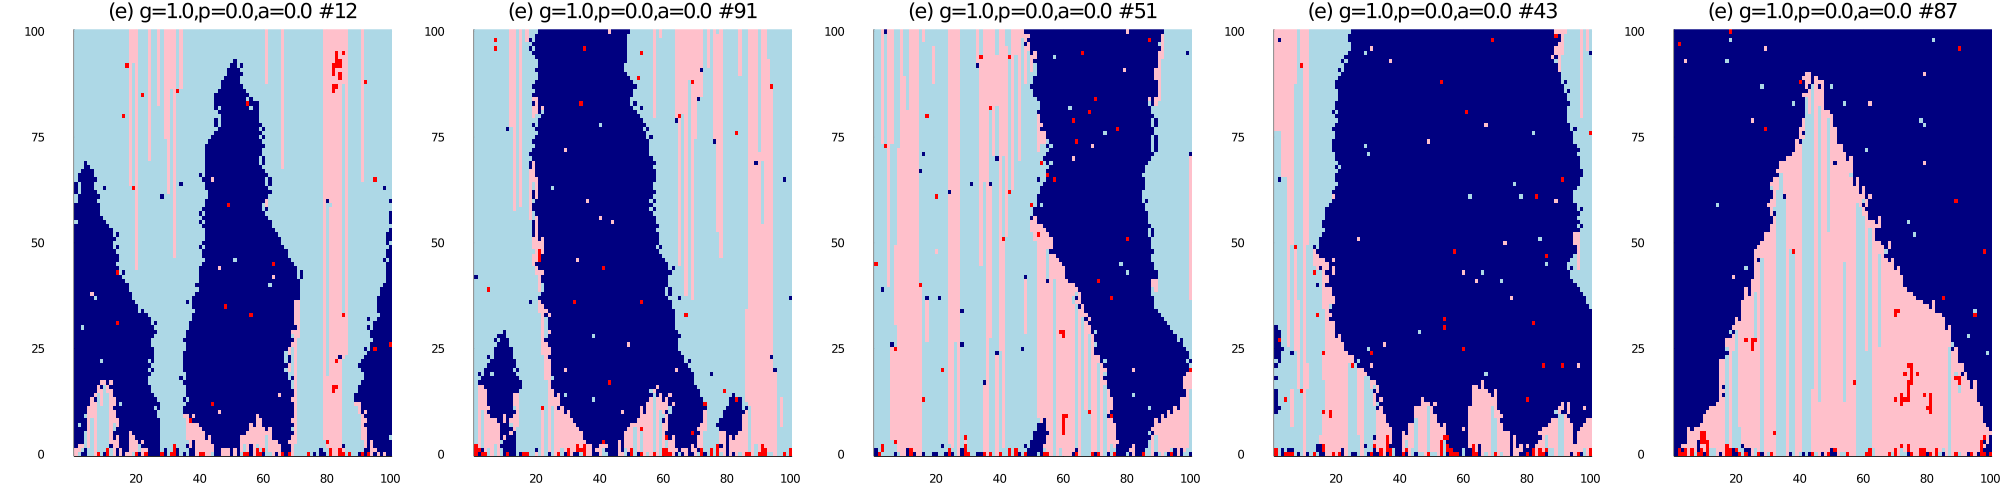

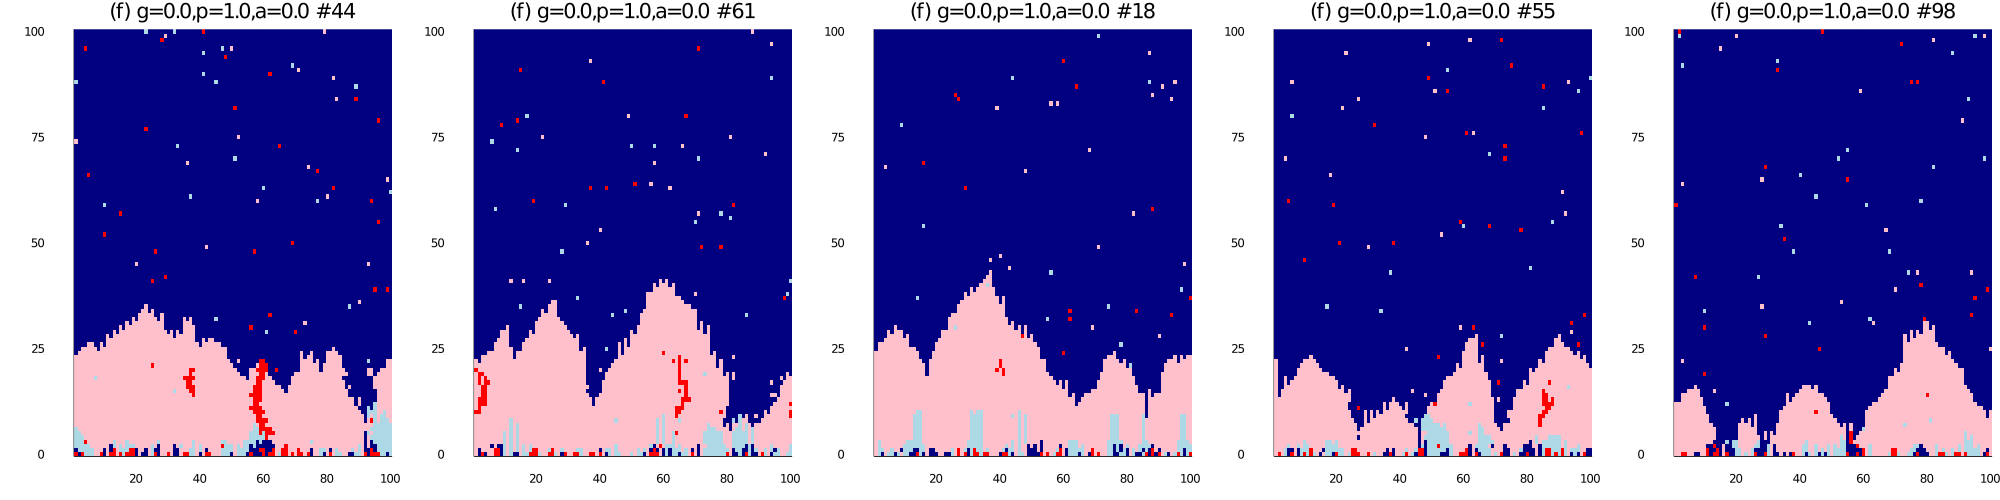

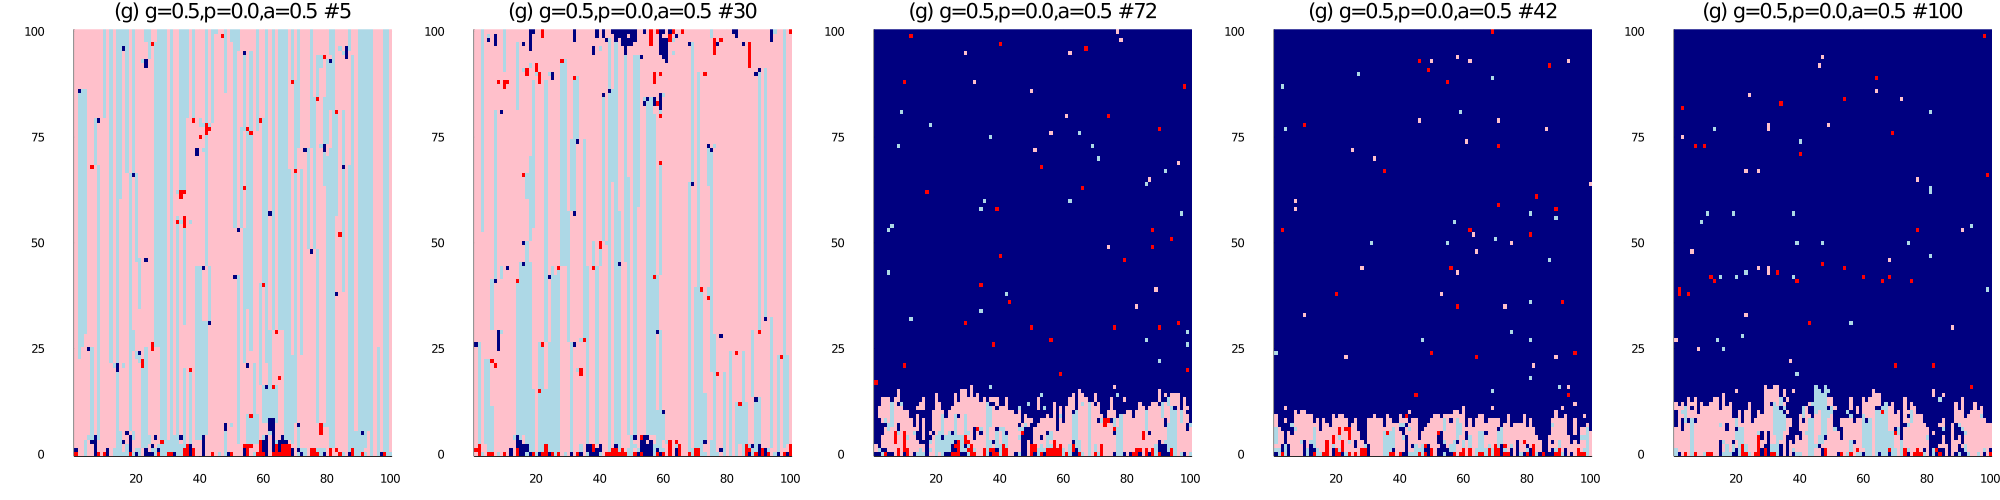

In [7]:
params = [("a", 1.0, 1.0, 1.0), ("b", 0.5, 0.25, 0.0), ("c", 0.0, 0.0, 0.0), ("d", 0.0, 0.0, 1.0), ("e", 1.0, 0.0, 0.0), ("f", 0.0, 1.0, 0.0), ("g", 0.5, 0.0, 0.5)]

for (_label, _g, _p, _a) in params
    # 協力度がベスト1, 25, 50, 75, 100の試行番号
    _trial_numbers = get_trial_numbers(df, _g, _p, _a)

    heatmaps = map(_trial_numbers) do _trial_number
        _df = transform_df(df, _g, _p, _a, _trial_number)

        function get_value(id::Int, step::Int)::Int
            _strategy = _df[_df.step .== step, Symbol(id)][1]

            if _strategy == "CP"
                4
            elseif _strategy == "CN"
                3
            elseif _strategy == "DP"
                2
            elseif _strategy == "DN"
                1
            end
        end

        heatmap(
            1:max_id,
            0:max_step,
            get_value,
            title="($(_label)) g=$(_g),p=$(_p),a=$(_a) #$(_trial_number)",
            color=palette([:navy, :red, :pink, :LightBlue], 4),
            colorbar=:none
        )
    end

    display(plot(
        heatmaps...,
        layout=(1, 5),
        size=(2000, 500),
        fmt=:png,
        top_margin=Measures.Length(:mm, 3.0),
        left_margin=Measures.Length(:mm, 6.0),
        right_margin=Measures.Length(:mm, 0.0),
        bottom_margin=Measures.Length(:mm, 6.0)
    ))
end